# Blogpost Article Generator - RNN
Author: Amelia Budiharto, Mark Cannel, Pascal Waser, Quyen Duong

## 1. Background Information
This notebook presents the code of text genetator for a blogpost article. The model trained using a article text under the category of technology. We used RNN deep learning model with word-by-word approaches. As a result, it aims to generate the next sequence of words based on the input keyword that we give in the beginning.

In [ ]:
# Install necessary package

!pip install datasets
#!pip install Unidecode

In [ ]:
import pandas as pd
import numpy as np
import string, os 
import platform
# from unidecode import unidecode
import re

# load dataset
from datasets import load_dataset

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Dropout, GRU, Lambda
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


# set seeds for reproducability
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

# warning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

print('Python version:', platform.python_version())
print('Tensorflow version:', tensorflow.__version__)
print('Keras version:', tensorflow.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


Connect to the Drive to save and retrieve's dataset and trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data

/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data


Increase to a higher RAM if available in Colab

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Load Dataset
This dataset is available in Tensorflow datasets https://www.tensorflow.org/datasets/catalog/ag_news_subset which can be retrieved using tensor data loader (tfds) or alternatively load through hugging face https://huggingface.co/datasets/ag_news#data-instances. This notebook load the dataset from hugging face API.

In [ ]:
# Load dataset
ori_news = load_dataset("ag_news", split = "train")
# ori_news = ori_news.remove_columns(['label'])

# Convert to pandas dataframe
dataframe_news = pd.DataFrame(ori_news)


Using custom data configuration default


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


In [ ]:
# Subset the dataset to only use 'technology' category label

dataframe_news_tech = dataframe_news.loc[dataframe_news['label'] == 3]

print("Technology news data points length: ", len(dataframe_news_tech))

Technology news data points length:  30000


In [ ]:
# Convert text to array

tech_texts_list = dataframe_news_tech.loc[:,'text']
tech_texts_array = tech_texts_list.values

In [ ]:
tech_texts_array[3]

'Companies Approve New High-Capacity Disc Format (Reuters) Reuters - A group of consumer electronics\\makers said on Wednesday they approved the format for a new\\generation of discs that can store five times the data of DVDs\\at the same cost -- enough to put a full season of "The\\Sopranos" on one disc.'

## 2. Cleaning Dataset
In thise step, we clean the text before preprocessed it. The cleaning steps include remove link, hashtag, redundant words, special character, and white space.

In [ ]:
# delete any url links in the tweet
def remove_link(text:str):
  return re.sub(r'(?:\s)http[^, ]*', '', text, flags=re.MULTILINE)

# remove line breaks
# def remove_newlines(text: str):
#   return re.sub('\n',  ' ', text) 

# remove certain words
def remove_word(text: str):
  return re.sub('reuters',  '', text) 

# only include string
def remove_special_characters(text: str):
  return re.sub(r'[^a-zA-Z\s]+', ' ', text, re.I | re.A)

# remove a word with only one character
def remove_single_word_character(text:str):
  return re.sub(r"\b[a-zA-Z]\b", '', text)

# remove white space
def remove_whitespace(text: str):
  return " ".join(re.split("\s+", text, flags=re.UNICODE))

def clean_text(texts_list):
  texts_list[:] = [remove_link(text) for text in texts_list]
  # texts_list[:] = [remove_newlines(text) for text in texts_list]
  texts_list[:] = [remove_special_characters(text) for text in texts_list]
  texts_list[:] = [text.lower() for text in texts_list]
  texts_list[:] = [remove_word(text) for text in texts_list]
  texts_list[:] = [remove_single_word_character(text) for text in texts_list]
  texts_list[:] = [remove_whitespace(text) for text in texts_list]


clean_text(tech_texts_array)
tech_texts_array[3]

'companies approve new high capacity disc format group of consumer electronics makers said on wednesday they approved the format for new generation of discs that can store five times the data of dvds at the same cost enough to put full season of the sopranos on one disc '

### Lemmatization
This step is to convert the words into the root (especially Verb) into the root word. We don't remove the stop words because it will make the word sequence unnatural.

In [ ]:
import nltk
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','entity','ner'])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [ ]:
import time

def lemmatize(text: str):
  return nlp(text)  

start_time = time.time()

# texts_list_lemmatized = [lemmatize(text) for text in texts_list]
texts_list_lemmatized = nlp.pipe(tech_texts_array, batch_size=32, n_process=3, disable=["parser", "entity", "ner"])

print("--- %s seconds ---" % (time.time() - start_time))

--- 4.839897155761719e-05 seconds ---


In [ ]:
def join_words(words):
  return ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in words])

start_time = time.time()

# docs1 = list(docs)[:2]
    
# result = [join_words(doc) for doc in docs1]
corpus = [join_words(text) for text in texts_list_lemmatized]
print(corpus[3])

print("--- %s seconds ---" % (time.time() - start_time))

company approve new high capacity disc format group of consumer electronic maker say on wednesday they approve the format for new generation of disc that can store five time the datum of dvds at the same cost enough to put full season of the soprano on one disc
--- 27.356048345565796 seconds ---


In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data/clean_text_tech_news.txt', 'w') as writefile:
  for element in corpus:
    writefile.write(element + ",")
  writefile.close()

## 3. Pre-processed Text
This step aims to save preprocessed text to extract the feature before fit in into the model

In [ ]:
# Load clean text to avoid running above codes

my_file = open("/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data/clean_text_tech_news.txt", "r")
content = my_file.read()

corpus = content.split(",")
my_file.close()

In [ ]:
corpus[3]

'company approve new high capacity disc format group of consumer electronic maker say on wednesday they approve the format for new generation of disc that can store five time the datum of dvds at the same cost enough to put full season of the soprano on one disc'

In [ ]:
# import nltk
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')

# corpus = word_tokenize(content)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Subset the vocabulary set in order to make training faster.
# With more computational power, we can increase to include the whole dataset for training.

small_corpus = corpus[1000:8000]

### Generating Sequence of N-gram Tokens
We tokenize and create sequence of token for each sentence. The sequence starts from bi-gram.

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(small_corpus):
    ## tokenization
    tokenizer.fit_on_texts(small_corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in small_corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(small_corpus)
inp_sequences[:10]

[[558, 2],
 [558, 2, 1687],
 [558, 2, 1687, 141],
 [558, 2, 1687, 141, 1570],
 [558, 2, 1687, 141, 1570, 39],
 [558, 2, 1687, 141, 1570, 39, 318],
 [558, 2, 1687, 141, 1570, 39, 318, 2819],
 [558, 2, 1687, 141, 1570, 39, 318, 2819, 244],
 [558, 2, 1687, 141, 1570, 39, 318, 2819, 244, 12],
 [558, 2, 1687, 141, 1570, 39, 318, 2819, 244, 12, 282]]

### Padding the Tokenize Sequence Word
Padding the sequence token into the same length

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

## Model Training
There are two type of RNN layer, GRU and LSTM.

### Model 1: GRU Bidirectional Model
The first model using GRU layer. GRU has two gates, it does not have an output gate that is present in LSTM. Instead, the reset gate is applied directly to the previous hidden state. 

Another differences, GRU model uses less training parameter which make it faster compare to LSTM.

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 100, input_length=input_len))
    
    # Add Hidden Layer 1 - Bidirectional LSTM Layer
    model.add(Bidirectional(GRU(100, return_sequences=True)))
    model.add(Dropout(0.1))

    # Add Hidden Layer 2 - LSTM Layer
    model.add(GRU(100))
    model.add(Dropout(0.2))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    adam = Adam(learning_rate=0.01,beta_1=0.001, beta_2=0.009)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 167, 100)          1285300   
                                                                 
 bidirectional (Bidirectiona  (None, 167, 200)         121200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 167, 200)          0         
                                                                 
 gru_1 (GRU)                 (None, 100)               90600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12853)             1298153   
                                                        

In [ ]:
from tensorflow.keras import callbacks
model_checkpoint =callbacks.ModelCheckpoint("RNN_GRU_Biderectional_checkpoint.h5", save_best_only=True)
early_stopping = callbacks.EarlyStopping(patience=50)

In [ ]:
history = model.fit(
    predictors, 
    label, 
    epochs=200, 
    batch_size=256, callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
878/878 [==============================] - 59s 62ms/step - loss: 7.2291 - accuracy: 0.0439
Epoch 2/200
878/878 [==============================] - 54s 62ms/step - loss: 6.7205 - accuracy: 0.0764
Epoch 3/200
878/878 [==============================] - 55s 62ms/step - loss: 6.2500 - accuracy: 0.1131
Epoch 4/200
878/878 [==============================] - 54s 62ms/step - loss: 5.9045 - accuracy: 0.1368
Epoch 5/200
878/878 [==============================] - 55s 62ms/step - loss: 5.6384 - accuracy: 0.1548
Epoch 6/200
878/878 [==============================] - 54s 62ms/step - loss: 5.4136 - accuracy: 0.1692
Epoch 7/200
878/878 [==============================] - 55s 62ms/step - loss: 5.2052 - accuracy: 0.1843
Epoch 8/200
878/878 [==============================] - 54s 62ms/step - loss: 5.0224 - accuracy: 0.1964
Epoch 9/200
878/878 [==============================] - 55s 62ms/step - loss: 4.8565 - accuracy: 0.2090
Epoch 10/200
878/878 [==============================] - 54s 62ms/step - l

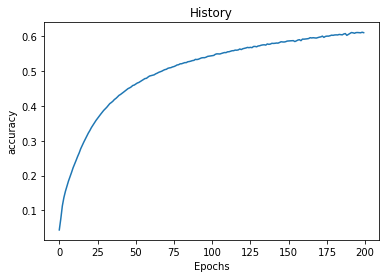

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title("History")
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.show()

In [ ]:
# save the model to file
model.save('TextGenerator_Bidirectional_GRU.h5')
# save the tokenizer
import pickle
pickle.dump(tokenizer, open('tokenizer_GRU.pkl', 'wb'))

#### Generate Text

In [ ]:
seed_text = "Television multimedia"
next_words = 100


for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # predict_x = model.predict(token_list)
  predict_x = np.argmax(model.predict(token_list, verbose=0), axis=-1)

  output_word = ""

  for word, index in tokenizer.word_index.items():
    if index == predict_x:
      output_word = word
      break

  seed_text += " " + output_word

print(seed_text)



Television multimedia friendly drive in the second quarter of wireless industry m and revenue increase as the second quarter of and gain percent compare to percent but also use to each people be to get it to use up to expect power from canada before you announce that they have to sell the e mail give a per cent over percent until the second half of accord to new research firm from forrester research inc find the first full time of the emerge market for those because they s lower level over human pressure accord to a report release thursday by lt


In [ ]:
seed_text = "Internet"
next_words = 100


for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # predict_x = model.predict(token_list)
  predict_x = np.argmax(model.predict(token_list, verbose=0), axis=-1)

  output_word = ""

  for word, index in tokenizer.word_index.items():
    if index == predict_x:
      output_word = word
      break

  seed_text += " " + output_word

print(seed_text)


Internet explorer lose more number of online music player and yahoo inc be likely to announce its long await initial public offering for per share to the market share search engine offer the same period last year by settle accord to report release monday by the federal communications commission report on friday it say it will offer large music download cost to create customer over the internet of its common large liquid crystal display information in the united states because of potential customer auction if the search engine be adopt the internet to download type in the country market accord to


In [ ]:
# save the model to file
model.save('TextGenerator_Bidirectional_GRU.h5')
# save the tokenizer
import pickle
pickle.dump(tokenizer, open('tokenizer_GRU.pkl', 'wb'))

The text seems not hundred percent fluent like a real human create it. Since we exlude all punctuation, there is no cut-off at all in the sentence which makes it not natual. It is also does not include any temperature parameter for the text prediction.

### Model 2: LSTM Bidirectional Model
The second model develop with LSTM bi-directional layer. LSTM has three gates, the input gate and target gate are coupled by an update gate.

The difference of bi-directional and regular LSTM is the process of making any neural network / sequence of information done in two direction backwards (future to past) and forward (past to future). 


In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 100, input_length=input_len))
    
    # Add Hidden Layer 1 - Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.2))

    # Add Hidden Layer 2 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    adam = Adam(learning_rate=0.1,beta_1=0.01, beta_2=0.09)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 167, 100)          1285300   
                                                                 
 bidirectional (Bidirectiona  (None, 167, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 167, 200)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12853)             1298153   
                                                        

In [ ]:
from tensorflow.keras import callbacks
model_checkpoint =callbacks.ModelCheckpoint("RNN_LSTM_Biderectional_checkpoint.h5", save_best_only=True)
early_stopping = callbacks.EarlyStopping(patience=50)

In [ ]:
history = model.fit(
    predictors, 
    label, 
    epochs=200, 
    batch_size=256, callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
482/482 [==============================] - 52s 98ms/step - loss: 7.3472 - accuracy: 0.0420
Epoch 2/200
482/482 [==============================] - 47s 98ms/step - loss: 7.1479 - accuracy: 0.0471
Epoch 3/200
482/482 [==============================] - 47s 98ms/step - loss: 6.9048 - accuracy: 0.0678
Epoch 4/200
482/482 [==============================] - 47s 98ms/step - loss: 6.5744 - accuracy: 0.0960
Epoch 5/200
482/482 [==============================] - 47s 98ms/step - loss: 6.2626 - accuracy: 0.1199
Epoch 6/200
482/482 [==============================] - 47s 98ms/step - loss: 5.9879 - accuracy: 0.1379
Epoch 7/200
482/482 [==============================] - 47s 98ms/step - loss: 5.7701 - accuracy: 0.1521
Epoch 8/200
482/482 [==============================] - 47s 98ms/step - loss: 5.5900 - accuracy: 0.1631
Epoch 9/200
482/482 [==============================] - 47s 98ms/step - loss: 5.4357 - accuracy: 0.1731
Epoch 10/200
482/482 [==============================] - 47s 98ms/step - l

In [ ]:
# save the model to file
model.save('TextGenerator_Bidirectional_LSTM2.h5')
# save the tokenizer
import pickle
pickle.dump(tokenizer, open('tokenizer_LSTM.pkl', 'wb'))

#### Generate Text

In [ ]:
seed_text = "Internet"
next_words = 100


for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # predict_x = model.predict(token_list)
  predict_x = np.argmax(model.predict(token_list, verbose=0), axis=-1)

  output_word = ""

  for word, index in tokenizer.word_index.items():
    if index == predict_x:
      output_word = word
      break

  seed_text += " " + output_word

print(seed_text)



Internet explorer job for the company most anticipate management developer be cut out to the right system to gain position as ibm will help business suite to gain the company infrastructure among business and the company say it manager to make the company demonstration of new system for linux that application release that microsoft corp say tuesday they be make security in the imac but the company say it will help the windows xp medium player solution and update release the release of handful of security platform for windows xp and windows server pack to sell from end server and expect


The LSTM layer does not give any better result compare with the GRU layer. The issue is still similar with GRU model that the sentence seems not fluent due to no punctuation.

## Step 5: Conclusion
Here is the finding after applying two RNN models based on word-to-word sequence approach to generate text:


**1. Analysis Overview**
- This model use use word-by-word sequence training approach which is try to predict what is the next keyword will be appeared alongside consider semantic understanding.

- There is trade-off between the computation power, training time, and the accuracy. As more vocabularies can be included as a parameter in the training model, it will give better semantic understanding in the genarated text.

- In brief, training deep learning model requires longer time and patience. Depending of the domain and the complexity of the text that we would like to analyze, we should consider whether to do complete self-trained text generation, include word embedding, or using a pre-trained model instead. Moreover, we can always try in the beginning to use pre-trained GPT transformer model to check how good pre-trained model already is and we can create masked layer to re-trained the model with our input dataset. 


**2. Model Understanding**
In general, we can increase the performance by tuning the hyper-parameter using cross validation grid search (e.g., dropout rate, learning rate, optimizer). However, this step also need more computational power and time which we do not able to fulfil due to limited RAM even already cut the parameter input into a batch. As one model run for several hours, we need to smartly think how to adjust the parameter for each run, else I will lost lot of time due to waiting the model to train.

Another issue with the word-by-word sequence, we will encounter billions of combination of sequence which fastly increase our vector matrix shape. Therefore, it also requires more computational power as we would like to include more parameter for our training.

**3. Future Engagement of the Project**
- This model can be improved by adding pre-training word embedding layer such as Glove or Gensim word2vec. 
- It can include temperature parameter in the generated text.
- Increase number of vocabulary in the training model.